<a href="https://colab.research.google.com/github/kridtapon/BolliBurst-Breakout/blob/main/BolliBurst_Breakout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.1 MB/s eta 0:00:00


In [ ]:
pip install --upgrade yfinance

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Function to calculate Bollinger Band Width
def calculate_bb_width(df, period=20):
    sma = df['Close'].rolling(window=period).mean()
    std = df['Close'].rolling(window=period).std()
    upper = sma + 2 * std
    lower = sma - 2 * std
    bb_width = (upper - lower) / sma
    return bb_width

# Function to detect breakout above previous N-day high
def calculate_breakout(df, lookback=20):
    prev_high = df['Close'].shift(1).rolling(window=lookback).max()
    breakout = df['Close'] > prev_high
    return breakout

# Download data
symbol = 'AXON'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Calculate Bollinger Band Width
df['BB_Width'] = calculate_bb_width(df, period=20)

# Calculate 10-day moving average of BB_Width to find expansions
df['BB_Width_MA'] = df['BB_Width'].rolling(window=10).mean()
df['Volatility_Expansion'] = df['BB_Width'] > df['BB_Width_MA']

# Detect breakout from previous 20-day high
df['Breakout'] = calculate_breakout(df, lookback=20)

# Combine conditions: Volatility Expansion & Breakout
df['Entry'] = df['Volatility_Expansion'] & df['Breakout']

# Define exit: price drops below previous 10-day low
df['Exit'] = df['Close'] < df['Close'].shift(10).rolling(window=10).min()

# Filter data for test period
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Backtest
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# Output
print(portfolio.stats())
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed


Start                                2020-01-02 00:00:00
End                                  2024-12-31 00:00:00
Period                                1258 days 00:00:00
Start Value                                     100000.0
End Value                                  459875.585843
Total Return [%]                              359.875586
Benchmark Return [%]                          676.280076
Max Gross Exposure [%]                             100.0
Total Fees Paid                              7641.668778
Max Drawdown [%]                               28.584549
Max Drawdown Duration                  377 days 00:00:00
Total Trades                                          18
Total Closed Trades                                   18
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                   61.111111
Best Trade [%]                                 58.701613
Worst Trade [%]                

[*********************100%***********************]  1 of 1 completed



Best Parameters:
BB_Period            20
Breakout_Lookback    10
Rolling_Window        7
Name: 4206, dtype: object

Stats:
Total Return [%]    5255.680076
Sharpe Ratio           1.702613
Max Drawdown [%]      43.555809
Name: 4206, dtype: object


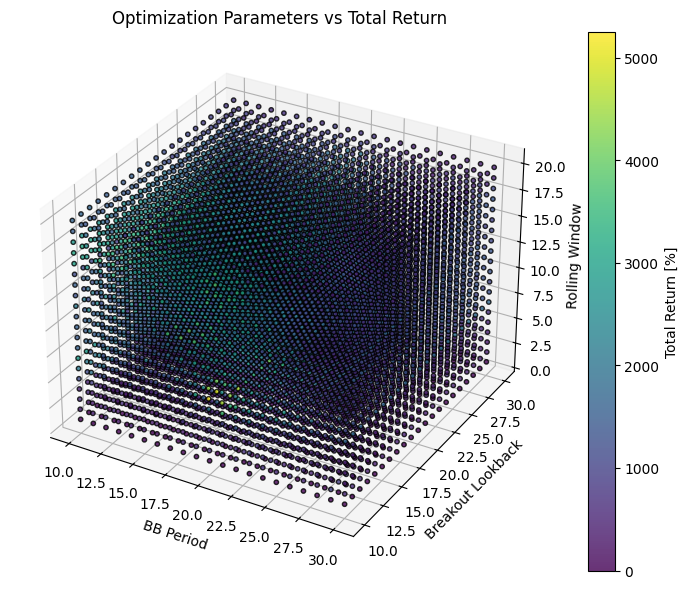

Start                         2020-01-01 00:00:00
End                           2024-12-31 00:00:00
Period                         1827 days 00:00:00
Start Value                              100000.0
End Value                           5355680.07601
Total Return [%]                      5255.680076
Benchmark Return [%]                  2447.768145
Max Gross Exposure [%]                      100.0
Total Fees Paid                     150447.776309
Max Drawdown [%]                        43.555809
Max Drawdown Duration           269 days 00:00:00
Total Trades                                   33
Total Closed Trades                            33
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            54.545455
Best Trade [%]                         136.875081
Worst Trade [%]                        -22.230925
Avg Winning Trade [%]                   35.419877
Avg Losing Trade [%]                    -6.674296


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
from itertools import product

# --- Custom Functions ---

def calculate_bb_width(df, period):
    sma = df['Close'].rolling(window=period).mean()
    std = df['Close'].rolling(window=period).std()
    upper = sma + 2 * std
    lower = sma - 2 * std
    bb_width = (upper - lower) / sma
    return bb_width

def calculate_breakout(df, lookback):
    prev_high = df['Close'].shift(1).rolling(window=lookback).max()
    breakout = df['Close'] > prev_high
    return breakout

# --- Download data ---

symbol = 'ETH-USD'
start_date = '2019-01-01'
end_date = '2025-01-01'

df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# --- Parameter Grid ---

bb_periods = range(10, 31)
breakout_lookbacks = range(10, 31)
rolling_windows = range(1, 21)

results = []

# --- Optimization Loop ---

for bb_p, breakout_p, roll_p in product(bb_periods, breakout_lookbacks, rolling_windows):
    df_temp = df.copy()

    df_temp['BB_Width'] = calculate_bb_width(df_temp, period=bb_p)
    df_temp['BB_Width_MA'] = df_temp['BB_Width'].rolling(window=roll_p).mean()
    df_temp['Volatility_Expansion'] = df_temp['BB_Width'] > df_temp['BB_Width_MA']
    df_temp['Breakout'] = calculate_breakout(df_temp, lookback=breakout_p)
    df_temp['Entry'] = df_temp['Volatility_Expansion'] & df_temp['Breakout']
    df_temp['Exit'] = df_temp['Close'] < df_temp['Close'].shift(roll_p).rolling(window=roll_p).min()

    # Filter for backtest period
    df_bt = df_temp[(df_temp.index.year >= 2020) & (df_temp.index.year <= 2025)]

    # Backtest
    pf = vbt.Portfolio.from_signals(
        close=df_bt['Close'],
        entries=df_bt['Entry'],
        exits=df_bt['Exit'],
        init_cash=100_000,
        fees=0.001,
        slippage=0.002,
        freq='D'
    )

    stats = pf.stats()
    results.append({
        'BB_Period': bb_p,
        'Breakout_Lookback': breakout_p,
        'Rolling_Window': roll_p,
        'Total Return [%]': stats.loc['Total Return [%]'],
        'Sharpe Ratio': stats.loc['Sharpe Ratio'],
        'Max Drawdown [%]': stats.loc['Max Drawdown [%]'],
        'Portfolio': pf
    })

# --- Find Best Result ---

results_df = pd.DataFrame(results)
best = results_df.sort_values(by='Total Return [%]', ascending=False).iloc[0]

print("\nBest Parameters:")
print(best[['BB_Period', 'Breakout_Lookback', 'Rolling_Window']])
print("\nStats:")
print(best[['Total Return [%]', 'Sharpe Ratio', 'Max Drawdown [%]']])

# --- 3D Plot of Optimized Parameters ---

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

xs = results_df['BB_Period']
ys = results_df['Breakout_Lookback']
zs = results_df['Rolling_Window']
returns = results_df['Total Return [%]']

sc = ax.scatter(xs, ys, zs, c=returns, cmap='viridis', s=10, edgecolors='k', alpha=0.8)
ax.set_xlabel('BB Period')
ax.set_ylabel('Breakout Lookback')
ax.set_zlabel('Rolling Window')
fig.colorbar(sc, label='Total Return [%]')
ax.set_title('Optimization Parameters vs Total Return')

plt.show()

# Plot best portfolio
best['Portfolio'].plot().show()
print(best['Portfolio'].stats())